# Reading Files

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import pandas as pd

df_test = pd.read_csv("dataset/x_test.csv")
raw_data = pd.read_csv("dataset/train.csv")
df_train = raw_data.copy(deep=True)
df_train.head()

,ID,Years Lived,Sex,Yearly Earnings,Relationship Status,Dependent Count,Academic Standing,Job Title,Wellness Index,Region,...,Prior Claims,Automobile Age,Financial Rating,Coverage Period,Coverage Commencement,Client Review,Tobacco Use,Physical Activity,Asset Category,Policy Cost
0,0,26.0,Man,8071.0,Unmarried,NaN,Secondary,NaN,17.927378,City,...,0.0,4.0,622.0,2.0,2024-06-10 15:21:39.261856,NaN,Smoker,Everyday,Residence,533.0
1,1,42.0,Man,49.0,Unmarried,2.0,Undergraduate,Jobless,49.828507,City,...,1.0,15.0,568.0,6.0,2023-01-06 15:21:39.272456,Moderate,Smoker,Once a Week,Unit,4795.0
2,2,52.0,Man,80793.0,Spouse,2.0,Doctorate,Jobless,27.539608,Exurban,...,2.0,2.0,467.0,7.0,2021-03-18 15:21:39.237118,Satisfactory,Non-Smoker,Seldom,Residence,151.0
3,3,33.0,Man,30663.0,Unmarried,1.0,Undergraduate,Freelancer,24.355045,Countryside,...,1.0,10.0,710.0,2.0,2023-08-28 15:21:39.102694,Unsatisfactory,Non-Smoker,Seldom,Residence,588.0
4,4,34.0,Man,59638.0,Spouse,0.0,Undergraduate,NaN,33.394840,Countryside,...,1.0,10.0,431.0,2.0,2024-03-17 15:21:39.171102,Unsatisfactory,Smoker,Once a Month,Residence,662.0


In [7]:
print(df_train.shape)
print(df_test.shape)

(1100000, 21)
(100000, 20)


In [8]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00


In [9]:
import os
import gc
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# Utility functions

In [10]:
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0.)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def reduce_mem_usage(df, verbose=True):
    """Reduce memory usage by downcasting numeric types."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mem: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df


# Preprocessing & EDA

In [11]:
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)

Mem: 176.24 MB -> 134.28 MB (23.8% reduction)
Mem: 15.26 MB -> 11.83 MB (22.5% reduction)


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1100000 non-null  int32  
 1   Years Lived            1082781 non-null  float32
 2   Sex                    1100000 non-null  object 
 3   Yearly Earnings        1058849 non-null  float32
 4   Relationship Status    1083018 non-null  object 
 5   Dependent Count        999297 non-null   float32
 6   Academic Standing      1100000 non-null  object 
 7   Job Title              771458 non-null   object 
 8   Wellness Index         1031954 non-null  float32
 9   Region                 1100000 non-null  object 
 10  Coverage Class         1100000 non-null  object 
 11  Prior Claims           766140 non-null   float32
 12  Automobile Age         1099994 non-null  float32
 13  Financial Rating       973595 non-null   float32
 14  Coverage Period   

In [13]:
df_train['Policy Cost'].describe()

,Policy Cost
count,1.100000e+06
mean,1.102681e+03
std,8.648780e+02
min,2.000000e+01
25%,5.140000e+02
50%,8.720000e+02
75%,1.509000e+03
max,4.999000e+03


In [14]:
df_train.isna().sum().sort_values(ascending=False)

,0
Prior Claims,333860
Job Title,328542
Financial Rating,126405
Dependent Count,100703
Client Review,71297
Wellness Index,68046
Yearly Earnings,41151
Years Lived,17219
Relationship Status,16982
Automobile Age,6


<Axes: xlabel='Policy Cost', ylabel='Density'>

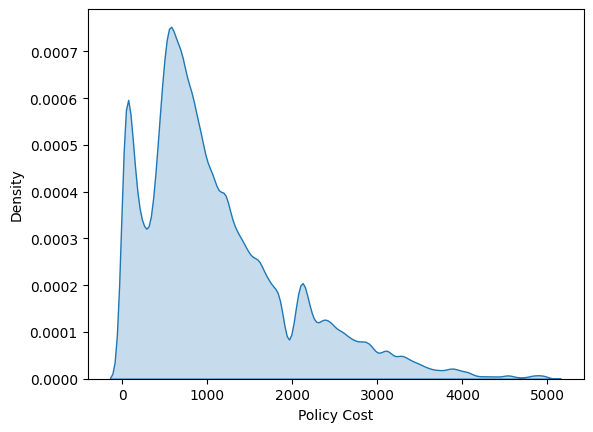

In [15]:
sns.kdeplot(df_train['Policy Cost'], fill=True)

In [16]:
TARGET = "Policy Cost"
ID_COL = "ID" if "ID" in df_train.columns else df_train.columns[0]

cols = [c for c in df_train.columns if c not in [TARGET]]
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET in num_cols:
    num_cols.remove(TARGET)

print("Numerical cols:", len(num_cols))
print("Categorical cols:", len(cat_cols))

Numerical cols: 9
Categorical cols: 11


In [17]:
num_cols.remove('ID')

Correlation

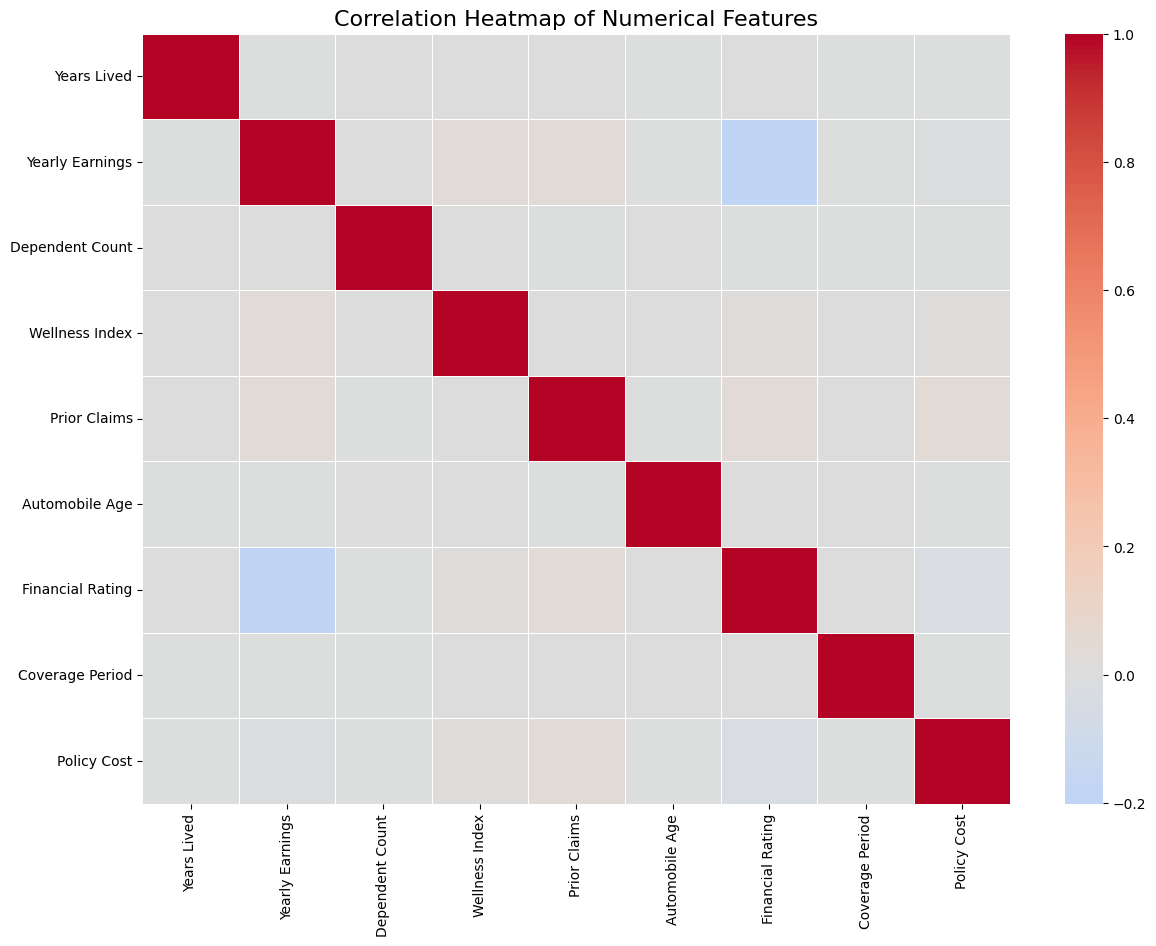

In [18]:
temp_num_cols = pd.concat([df_train[num_cols], df_train[TARGET]], axis=1)
corr_matrix = temp_num_cols.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=False,
            fmt=".2f",
            linewidths=0.5)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

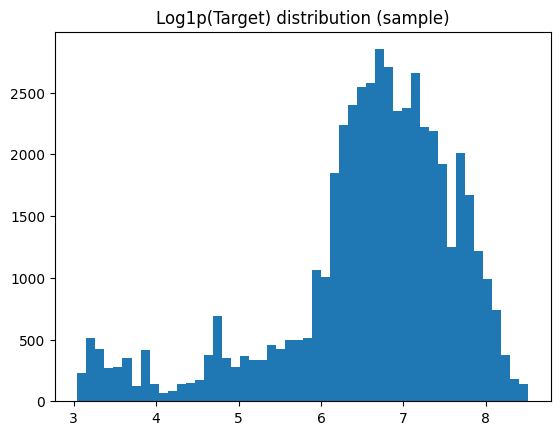

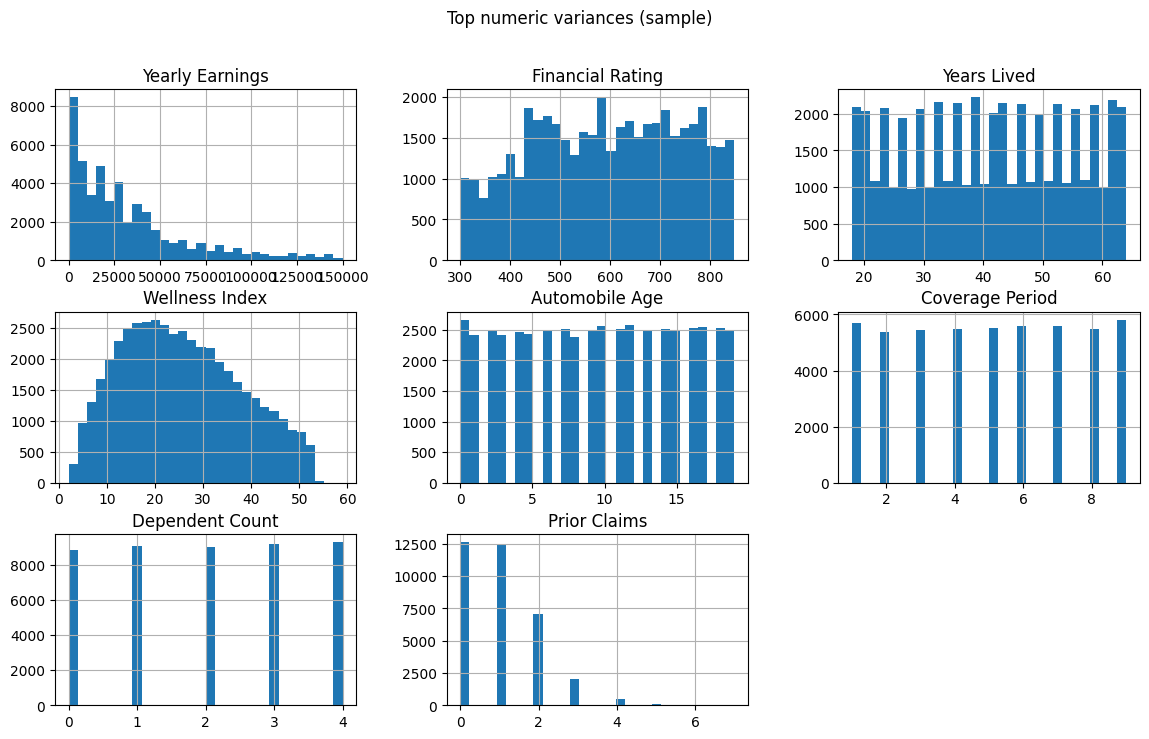

In [19]:
df_sample = df_train.sample(50000, random_state=42) if len(df_train) > 50000 else df_train.copy()

plt.hist(np.log1p(df_sample[TARGET]), bins=50)
plt.title("Log1p(Target) distribution (sample)")
plt.show()

num_var = df_sample[num_cols].var().sort_values(ascending=False).head(10).index.tolist()
df_sample[num_var].hist(bins=30, figsize=(14,8))
plt.suptitle("Top numeric variances (sample)")
plt.show()

# Feature engineering

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold


def find_date_col(df, candidates=('coverage','commenc','date')):
    for c in df.columns:
        lc = c.lower()
        if any(tok in lc for tok in candidates):
            return c
    return None

def add_temporal_features(df_train, df_test, date_col):
    if date_col is None:
        return df_train, df_test, None
    for df in (df_train, df_test):
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df[f"{date_col}_year"] = df[date_col].dt.year.fillna(-1).astype(int)
        df[f"{date_col}_month"] = df[date_col].dt.month.fillna(-1).astype(int)
        df[f"{date_col}_dayofweek"] = df[date_col].dt.dayofweek.fillna(-1).astype(int)
        df[f"{date_col}_dayofyear"] = df[date_col].dt.dayofyear.fillna(-1).astype(int)
        # season (0=spring,1=summer,2=autumn,3=winter) approximate by month
        df[f"{date_col}_season"] = df[f"{date_col}_month"].map({
            3:0,4:0,5:0,   # spring
            6:1,7:1,8:1,   # summer
            9:2,10:2,11:2, # autumn
            12:3,1:3,2:3   # winter
        }).fillna(-1).astype(int)
    return df_train, df_test, date_col

def add_policy_age(df_train, df_test, date_col, ref_date=None):
    if date_col is None:
        return df_train, df_test
    if ref_date is None:
        ref = max(df_train[date_col].max(), pd.Timestamp.today())
    else:
        ref = pd.to_datetime(ref_date)
    for df in (df_train, df_test):
        df[f"{date_col}_policy_age_days"] = (ref - df[date_col]).dt.days.fillna(-1).astype(int)
    return df_train, df_test

def log_transform_skewed(df_train, df_test, numeric_cols, thresh=1.0):
    skewness = df_train[numeric_cols].skew().abs()
    to_log = skewness[skewness > thresh].index.tolist()
    for c in to_log:
        new = c + "_log1p"
        df_train[new] = np.log1p(df_train[c].clip(lower=0))
        df_test[new]  = np.log1p(df_test[c].clip(lower=0))
    return df_train, df_test, to_log

def bin_numeric(df_train, df_test, cols_to_bin, n_bins=5, prefix="bin"):
    for c in cols_to_bin:
        new = f"{prefix}_{c}"
        combined = pd.concat([df_train[c], df_test[c]], axis=0)
        # use qcut on combined to keep consistent bins; if qcut fails (duplicates), use cut
        try:
            bins = pd.qcut(combined.rank(method='first'), q=n_bins, labels=False, duplicates='drop')
            df_train[new] = bins.iloc[:len(df_train)].astype('int8')
            df_test[new]  = bins.iloc[len(df_train):].astype('int8')
        except Exception:
            bins = pd.cut(combined, bins=n_bins, labels=False)
            df_train[new] = bins.iloc[:len(df_train)].fillna(-1).astype('int8')
            df_test[new]  = bins.iloc[len(df_train):].fillna(-1).astype('int8')
    return df_train, df_test

def combine_rare_categories(df_train, df_test, col, min_pct=0.01):
    freq = df_train[col].value_counts(normalize=True)
    keep = freq[freq >= min_pct].index
    df_train[col] = df_train[col].where(df_train[col].isin(keep), other="Other")
    df_test[col]  = df_test[col].where(df_test[col].isin(keep), other="Other")
    return df_train, df_test

def create_cat_interaction(df_train, df_test, cols_pair):
    a,b = cols_pair
    new = f"{a}__{b}"
    df_train[new] = (df_train[a].astype(str) + "___" + df_train[b].astype(str))
    df_test[new]  = (df_test[a].astype(str)  + "___" + df_test[b].astype(str))
    return df_train, df_test, new

def oof_mean_target_encode(df_train, df_test, col, target, n_splits=5, smoothing=20, seed=42):
    oof = np.zeros(len(df_train))
    test_encoded = np.zeros(len(df_test))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    test_folds = np.zeros((len(df_test), n_splits))
    global_mean = df_train[target].mean()
    for i, (tr_idx, val_idx) in enumerate(kf.split(df_train)):
        tr = df_train.iloc[tr_idx]
        val = df_train.iloc[val_idx]
        stats = tr.groupby(col)[target].agg(['mean','count'])
        counts = stats['count']
        means = stats['mean']
        smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
        val_map = val[col].map(smooth).fillna(global_mean).values
        oof[val_idx] = val_map
        test_folds[:, i] = df_test[col].map(smooth).fillna(global_mean).values
    test_encoded = test_folds.mean(axis=1)
    new_col = col + "_te"
    df_train[new_col] = oof
    df_test[new_col]  = test_encoded
    return df_train, df_test, new_col


# detect date column
date_col = find_date_col(df_train)
df_train, df_test, date_col = add_temporal_features(df_train, df_test, date_col)

# add policy age relative to reference (optional: provide date string for reproducibility)
if date_col is not None:
    df_train, df_test = add_policy_age(df_train, df_test, date_col, ref_date=None)

# refresh numeric & categorical lists
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object','category']).columns.tolist()
if TARGET in num_cols: num_cols.remove(TARGET)
if 'ID' in num_cols: num_cols.remove('ID')

# log-transform skewed numeric features
df_train, df_test, logged = log_transform_skewed(df_train, df_test, num_cols, thresh=1.0)

# bin some numeric features (choose sensible candidates or top skewed)
candidates_to_bin = []
# heuristics: pick if distinct values > 20 and not an id/date column
for c in num_cols:
    if df_train[c].nunique() > 20 and 'year' not in c.lower() and 'id' not in c.lower():
        candidates_to_bin.append(c)
candidates_to_bin = candidates_to_bin[:6]  # limit to 6 to avoid explosion
df_train, df_test = bin_numeric(df_train, df_test, candidates_to_bin, n_bins=5, prefix="bin")

# create numeric interaction terms (choose a few)
num_interactions = []
numeric_for_inter = [c for c in num_cols if c in ['Years Lived','Prior Claims','Yearly Earnings','Dependent Count','Premium Amount'] if c in df_train.columns]
for i in range(len(numeric_for_inter)):
    for j in range(i+1, len(numeric_for_inter)):
        a = numeric_for_inter[i]
        b = numeric_for_inter[j]
        new = f"{a}__{b}_mul"
        df_train[new] = df_train[a].fillna(0) * df_train[b].fillna(0)
        df_test[new]  = df_test[a].fillna(0) * df_test[b].fillna(0)
        num_interactions.append(new)

# combine rare categories for high-cardinality categorical columns
high_card_cols = [c for c in cat_cols if df_train[c].nunique() > 50]
for c in high_card_cols:
    df_train, df_test = combine_rare_categories(df_train, df_test, c, min_pct=0.005)

# categorical interaction features (choose pairs from small set)
cat_for_inter = [c for c in cat_cols if c in ['Sex','Relationship Status','Occupation','Plan Type','Region'] and c in df_train.columns]
cat_pairs = []
for i in range(len(cat_for_inter)):
    for j in range(i+1, len(cat_for_inter)):
        df_train, df_test, newcol = create_cat_interaction(df_train, df_test, (cat_for_inter[i], cat_for_inter[j]))
        cat_pairs.append(newcol)

# Target-encoding for a shortlist of high-cardinality cols (OOF)
# use target_log1p if your model trains on log target (y_log); here use target column 'target_log1p' if present or create it
if 'target_log1p' not in df_train.columns:
    df_train['target_log1p'] = np.log1p(df_train[TARGET])
shortlist_te = [c for c in high_card_cols][:6]  # limit to 6
te_new_cols = []
for c in shortlist_te:
    df_train, df_test, newcol = oof_mean_target_encode(df_train, df_test, c, target='target_log1p', n_splits=5, smoothing=20)
    te_new_cols.append(newcol)

# refresh feature lists (important before modeling)
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object','category']).columns.tolist()
if TARGET in num_cols: num_cols.remove(TARGET)
if 'target_log1p' in num_cols: num_cols.remove('target_log1p')
if 'ID' in num_cols: num_cols.remove('ID')

print("Temporal date column:", date_col)
print("Created log features:", logged)
print("Binned columns:", candidates_to_bin)
print("Numeric interactions:", num_interactions)
print("Categorical interaction cols:", cat_pairs)
print("Target-encoded cols:", te_new_cols)
print("Updated num_cols count:", len(num_cols), "Updated cat_cols count:", len(cat_cols))


/tmp/ipython-input-1733604079.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
/tmp/ipython-input-1733604079.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


Temporal date column: Coverage Class
Created log features: ['Yearly Earnings']
Binned columns: ['Wellness Index', 'Financial Rating']
Numeric interactions: ['Years Lived__Yearly Earnings_mul', 'Years Lived__Dependent Count_mul', 'Years Lived__Prior Claims_mul', 'Yearly Earnings__Dependent Count_mul', 'Yearly Earnings__Prior Claims_mul', 'Dependent Count__Prior Claims_mul']
Categorical interaction cols: ['Sex__Relationship Status', 'Sex__Region', 'Relationship Status__Region']
Target-encoded cols: ['Coverage Commencement_te']
Updated num_cols count: 24 Updated cat_cols count: 13


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 41 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   ID                                    1100000 non-null  int32         
 1   Years Lived                           1082781 non-null  float32       
 2   Sex                                   1100000 non-null  object        
 3   Yearly Earnings                       1058849 non-null  float32       
 4   Relationship Status                   1083018 non-null  object        
 5   Dependent Count                       999297 non-null   float32       
 6   Academic Standing                     1100000 non-null  object        
 7   Job Title                             771458 non-null   object        
 8   Wellness Index                        1031954 non-null  float32       
 9   Region                                1100000 

In [23]:
df_train = reduce_mem_usage(df_train)
df_test  = reduce_mem_usage(df_test)

Mem: 253.87 MB -> 201.42 MB (20.7% reduction)
Mem: 22.32 MB -> 17.55 MB (21.4% reduction)


# Models

### Ridge

In [24]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

TARGET = "Policy Cost"
y = df_train[TARGET].values
y_log = np.log1p(y)  # log-transform for RMSLE

# Identify numerical and categorical columns
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target, ID, and target_log1p from feature lists
if TARGET in num_cols:
    num_cols.remove(TARGET)
if ID_COL in num_cols:
    num_cols.remove(ID_COL)
if 'target_log1p' in num_cols:
    num_cols.remove('target_log1p')


# Identify low cardinality categorical columns for OneHotEncoding
low_card_cat = [c for c in cat_cols if df_train[c].nunique() <= 20]
# Identify high cardinality categorical columns (will be dropped for this baseline)
high_card_cat = [c for c in cat_cols if df_train[c].nunique() > 20]

# Assuming 'Client Review', 'Tobacco Use', 'Physical Activity', 'Academic Standing' are ordinal
ordinal_cols = ['Client Review', 'Tobacco Use', 'Physical Activity', 'Academic Standing']
# Ensure ordinal_cols only contains columns present in the current cat_cols
ordinal_cols = [c for c in ordinal_cols if c in cat_cols]

nominal_cols = [c for c in low_card_cat if c not in ordinal_cols]


# Create transformers for different column types, including imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute numerical NaNs
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), # Impute categorical NaNs
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) # Ordinal encode
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), # Impute categorical NaNs
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode
])

# Get all feature columns that will be used by the preprocessor
all_feature_cols = num_cols + ordinal_cols + nominal_cols


# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='drop' # Drop columns not specified (including high cardinality categorical and ID)
)

# Create the full pipeline including preprocessing and the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', Ridge(random_state=42))])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(df_train))
test_preds = np.zeros(len(df_test))

# Fit and predict with cross-validation
for fold, (tr_idx, val_idx) in enumerate(kf.split(df_train)):
    # Select only the feature columns for training and validation
    tr_X, val_X = df_train[all_feature_cols].iloc[tr_idx], df_train[all_feature_cols].iloc[val_idx]
    tr_y, val_y = y_log[tr_idx], y_log[val_idx]

    model.fit(tr_X, tr_y)
    preds = model.predict(val_X)
    oof_preds[val_idx] = preds

    rmsle_fold = np.sqrt(mean_squared_log_error(np.expm1(val_y), np.expm1(preds)))
    print(f"Fold {fold+1} RMSLE: {rmsle_fold:.5f}")

cv_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_log), np.expm1(oof_preds)))
print(f"Overall CV RMSLE (Ridge Regression): {cv_rmsle:.5f}")

# Fit the model on the entire training data (excluding target and ID) and predict on the test set
model.fit(df_train[all_feature_cols], y_log)
test_preds = model.predict(df_test[all_feature_cols])
test_preds = np.expm1(test_preds)  # invert log1p

# Load the submission file
sub = pd.read_csv('dataset/sample_submission.csv')

# Create the submission file
submission = sub.copy()
submission["Policy Cost"] = test_preds
submission.to_csv("ridge_submission.csv", index=False)
print("Saved ridge_submission.csv")

Fold 1 RMSLE: 1.08563
Fold 2 RMSLE: 1.08452
Fold 3 RMSLE: 1.08531
Fold 4 RMSLE: 1.08451
Fold 5 RMSLE: 1.08299
Overall CV RMSLE (Ridge Regression): 1.08459
Saved ridge_submission.csv


### ElasticNet

In [26]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

TARGET = "Policy Cost"
y = df_train[TARGET].values
y_log = np.log1p(y)

# Identify numerical and categorical columns
num_cols = df_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target, ID, and target_log1p from feature lists
if TARGET in num_cols:
    num_cols.remove(TARGET)
if ID_COL in num_cols:
    num_cols.remove(ID_COL)
if 'target_log1p' in num_cols:
    num_cols.remove('target_log1p')

# Identify low cardinality categorical columns for OneHotEncoding
low_card_cat = [c for c in cat_cols if df_train[c].nunique() <= 20]
# Identify high cardinality categorical columns (will be dropped for this baseline)
high_card_cat = [c for c in cat_cols if df_train[c].nunique() > 20]

# Assuming 'Client Review', 'Tobacco Use', 'Physical Activity', 'Academic Standing' are ordinal
ordinal_cols = ['Client Review', 'Tobacco Use', 'Physical Activity', 'Academic Standing']
# Ensure ordinal_cols only contains columns present in the current cat_cols
ordinal_cols = [c for c in ordinal_cols if c in cat_cols]

nominal_cols = [c for c in low_card_cat if c not in ordinal_cols]

# Create transformers for different column types, including imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Get all feature columns that will be used by the preprocessor
all_feature_cols = num_cols + ordinal_cols + nominal_cols

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
    ],
    remainder='drop'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(df_train))
test_preds = np.zeros(len(df_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(df_train)):
    # Select only the feature columns for training and validation
    tr_X, val_X = df_train[all_feature_cols].iloc[tr_idx], df_train[all_feature_cols].iloc[val_idx]
    tr_y, val_y = y_log[tr_idx], y_log[val_idx]

    model.fit(tr_X, tr_y)
    preds = model.predict(val_X)
    oof_preds[val_idx] = preds

    rmsle_fold = np.sqrt(mean_squared_log_error(np.expm1(val_y), np.expm1(preds)))
    print(f"Fold {fold+1} RMSLE: {rmsle_fold:.5f}")

cv_rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_log), np.expm1(oof_preds)))
print(f"Overall CV RMSLE (ElasticNet): {cv_rmsle:.5f}")

# Fit the model on the entire training data (excluding target and ID) and predict on the test set
model.fit(df_train[all_feature_cols], y_log)
test_preds = model.predict(df_test[all_feature_cols])
test_preds = np.expm1(test_preds)

sub = pd.read_csv('dataset/sample_submission.csv')
submission = sub.copy()
submission["Policy Cost"] = test_preds
submission.to_csv("elasticnet_submission.csv", index=False)
print("Saved elasticnet_submission.csv")

Fold 1 RMSLE: 1.09374
Fold 2 RMSLE: 1.09232
Fold 3 RMSLE: 1.09340
Fold 4 RMSLE: 1.09217
Fold 5 RMSLE: 1.09061
Overall CV RMSLE (ElasticNet): 1.09245
Saved elasticnet_submission.csv
